<a href="https://colab.research.google.com/github/afaqahmed91/deeplearning/blob/main/notebooks/indoor_temperature_predictor/Timeseries_RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Alcohol_Sales.csv to Alcohol_Sales.csv


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv("Alcohol_Sales.csv", index_col = "DATE", parse_dates = True)
df.index.freq = "MS"

In [5]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


<Axes: xlabel='DATE'>

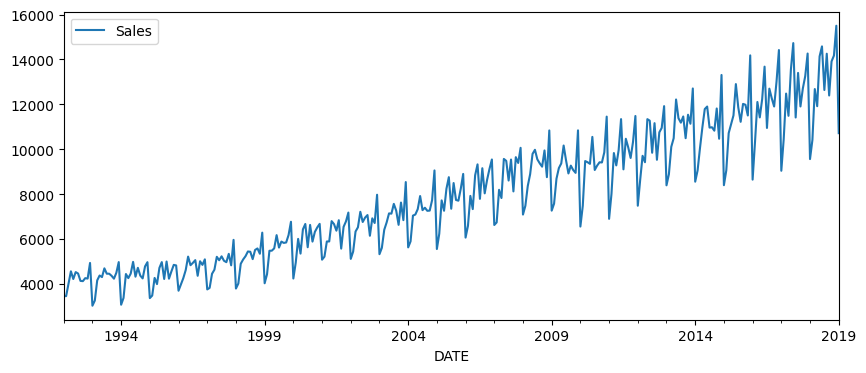

In [6]:
df.columns = ["Sales"]
df.plot(figsize = (10,4))

In [8]:
!pip install statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

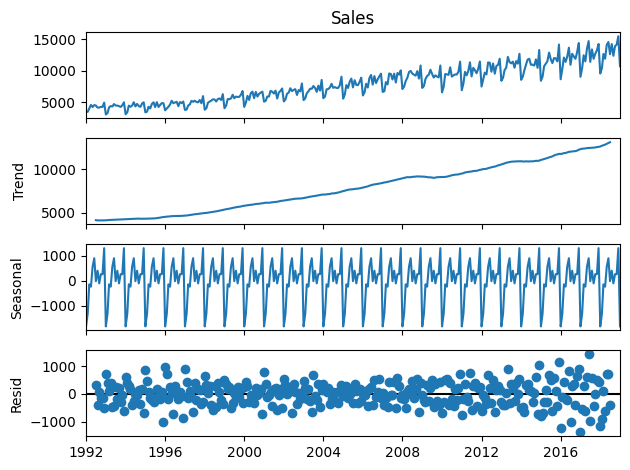

In [11]:
results = seasonal_decompose(df["Sales"])
results.plot();

<Axes: xlabel='DATE'>

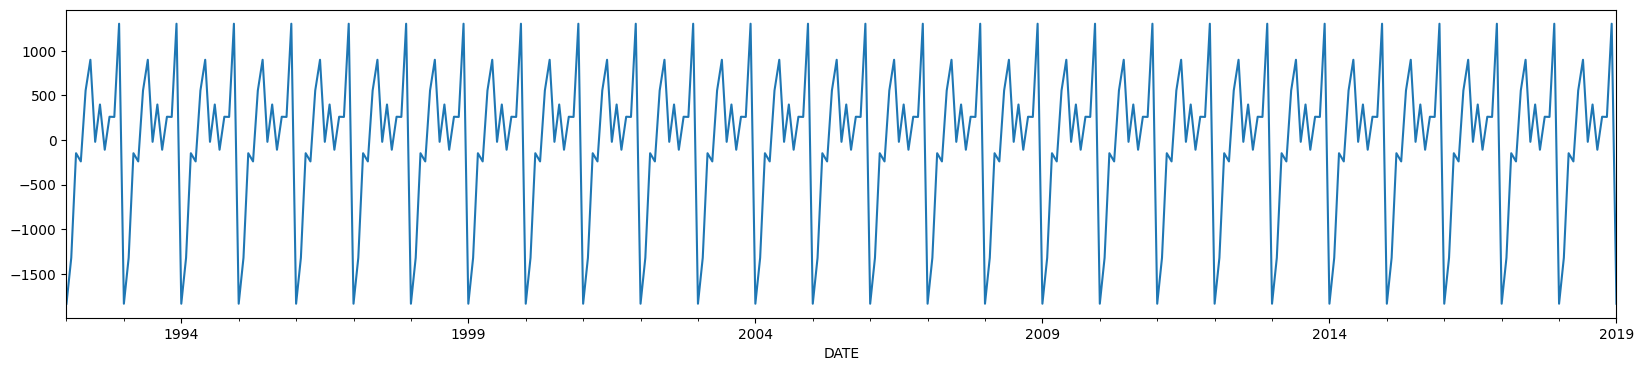

In [13]:
results.seasonal.plot(figsize = (20,4))

In [14]:
df.head()

,Sales
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [15]:
train = df.iloc[:313]
test = df.iloc[313:]

In [16]:
# You need to scale the data

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train) # always fit to the test data as you will not know the data in the future

MinMaxScaler()

In [23]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test) # use the same scalar to fit the test as well

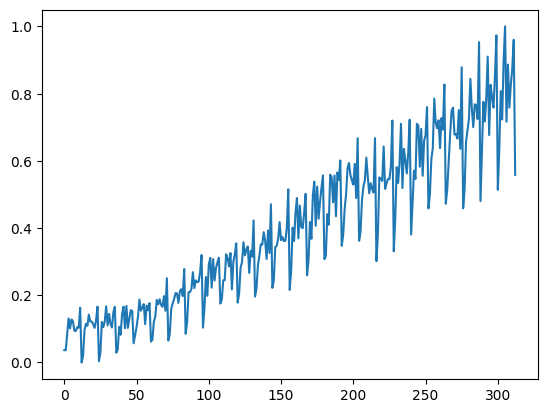

In [22]:
plt.plot(scaled_train)

LSTM need a set of lagged values and the actual current value to predict
`[t-1, t-2, t-3] , [t]`

In [31]:
import tensorflow as tf

In [35]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [121]:
n_inputs = 12 # training sequence (you should take into account for the seasonality)
n_features = 1 # columns of data
generator = TimeseriesGenerator(data = scaled_train, targets = scaled_train,length =  n_lagged_inputs, batch_size = 1)

In [122]:
generator[0]

(array([[[0.03658432],
         [0.03649885],
         [0.08299855],
         [0.13103684],
         [0.1017181 ],
         [0.12804513],
         [0.12266006],
         [0.09453799],
         [0.09359774],
         [0.10496624],
         [0.10334217],
         [0.16283443]]]),
 array([[0.]]))

In [123]:
scaled_train[:13]

array([[0.03658432],
       [0.03649885],
       [0.08299855],
       [0.13103684],
       [0.1017181 ],
       [0.12804513],
       [0.12266006],
       [0.09453799],
       [0.09359774],
       [0.10496624],
       [0.10334217],
       [0.16283443],
       [0.        ]])

<img src="https://www.researchgate.net/profile/Savvas_Varsamopoulos/publication/329362532/figure/download/fig5/AS:699592479870977@1543807253596/Structure-of-the-LSTM-cell-and-equations-that-describe-the-gates-of-an-LSTM-cell.jpg" alt="Drawing"/>

In [124]:
### Defining the RNN Model structure ###
def build_model(rnn_units, n_input, n_features):
  model = tf.keras.Sequential([

    # Layer 1: LSTM with `rnn_units` number of units.
    # TODO: Call the LSTM function defined above to add this layer.
    tf.keras.layers.LSTM(
    rnn_units,
    activation='relu', # (default = tanh) final activation is tanh
    recurrent_initializer='glorot_uniform', # default
    recurrent_activation='sigmoid', # (default) internal activation is signmoid
    input_shape=(n_input, n_features),
    ),

    # Layer 2: Dense (fully-connected) layer that transforms the LSTM output
    #   into the vocabulary size.
    # TODO: Add the Dense layer.
    tf.keras.layers.Dense(1)
  ])

  return model


In [125]:
model = build_model(150, n_inputs, n_features)

In [126]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 150)               91200     
                                                                 
 dense_4 (Dense)             (None, 1)                 151       
                                                                 
Total params: 91351 (356.84 KB)
Trainable params: 91351 (356.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [127]:
### Defining the loss function ###

'''TODO: define the loss function to compute and return the loss between
    the true labels and predictions (logits). Set the argument from_logits=True.'''
def compute_loss(labels, logits):
  loss = tf.keras.losses.MeanSquaredError()
  return loss(labels,logits)

'''TODO: compute the loss using the true next characters from the example batch
    and the predictions from the untrained model several cells above'''
example_batch_loss = compute_loss([[5]], [[4.5]]) # TODO
print("scalar_loss:      ", example_batch_loss.numpy().mean())

scalar_loss:       0.25


In [128]:
### Defining the Optimezer ###
'''Checkout the tensorflow website for a list of supported optimizers.
  https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/
  Try using the Adam optimizer to start.'''
optimizer = tf.keras.optimizers.Adam(
    learning_rate = 0.001, # default
    )


In [129]:
### Define training operation ###

@tf.function
def train_step(x, y):
  # Use tf.GradientTape()
  with tf.GradientTape() as tape:

    '''feed the current input into the model and generate predictions'''
    y_hat = model(x)

    '''compute the loss!'''
    loss = compute_loss(y, y_hat)

  # Now, compute the gradients
  '''complete the function call for gradient computation.
      Remember that we want the gradient of the loss with respect all
      of the model parameters.'''
  grads = tape.gradient(loss, model.trainable_variables)

  # Apply the gradients to the optimizer so it can update the model accordingly
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss

In [131]:


##################
# Begin training!#
##################

history = {}

for epoch in range(0, 25):
  history[epoch] = []
  for i in range(0,generator.__len__()):
    loss = train_step(generator[i][0],generator[i][1] )
    # Print the loss
    loss_val = loss.numpy().mean()
    history[epoch].append(loss_val)
  print(f'Epoch {epoch + 1}, Loss: {loss_val}')


Epoch 1, Loss: 0.01751711405813694
Epoch 2, Loss: 1.348755176877603e-05
Epoch 3, Loss: 0.0001292498636757955
Epoch 4, Loss: 0.0003404472954571247
Epoch 5, Loss: 0.0010860000038519502
Epoch 6, Loss: 0.0016191080212593079
Epoch 7, Loss: 0.0019467913080006838
Epoch 8, Loss: 0.0020208086352795362
Epoch 9, Loss: 0.0022311576176434755
Epoch 10, Loss: 0.002889284398406744
Epoch 11, Loss: 0.0032018907368183136
Epoch 12, Loss: 0.003010227344930172
Epoch 13, Loss: 0.0031486758962273598
Epoch 14, Loss: 0.002615233650431037
Epoch 15, Loss: 0.0024377433583140373
Epoch 16, Loss: 0.002287137322127819
Epoch 17, Loss: 0.002162485383450985
Epoch 18, Loss: 0.000803073518909514
Epoch 19, Loss: 0.0011433068430051208
Epoch 20, Loss: 0.0009481728193350136
Epoch 21, Loss: 0.0006628865958191454
Epoch 22, Loss: 0.0008941534324549139
Epoch 23, Loss: 0.0001358411682303995
Epoch 24, Loss: 0.0026436152402311563
Epoch 25, Loss: 0.002508878242224455


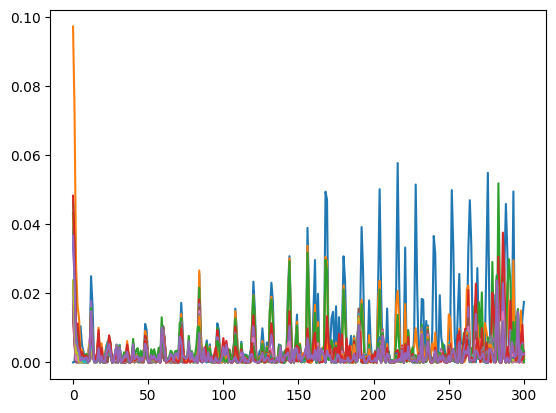

In [132]:
for key in history:
  plt.plot(history[key], label = f"Epoch{key}")

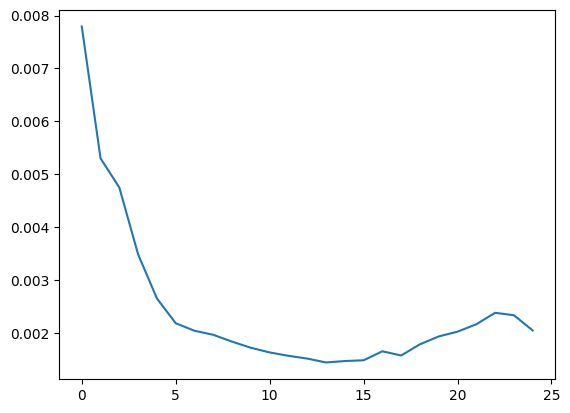

In [134]:
plt.plot(history.keys(), [np.mean(val)  for val in history.values()])

In [142]:
generator[300]

(array([[[0.51389008],
         [0.63432772],
         [0.80776135],
         [0.72313873],
         [0.89870929],
         [1.        ],
         [0.71672793],
         [0.88648602],
         [0.75869732],
         [0.82742115],
         [0.87443371],
         [0.96025301]]]),
 array([[0.5584238]]))

In [135]:
#future
def generate_text(model, input_eval, generation_length=12):
  # Empty string to store our results
  generated_val = []


  for i in range(generation_length):
      '''TODO: evaluate the inputs and generate the next character predictions'''
      predictions = model(input_eval)


In [151]:
predictions = model(generator[300][0])
predictions = tf.squeeze(predictions, 0).numpy()

In [152]:
predictions

array([0.49056426], dtype=float32)

In [147]:
input_eval = generator[300][0]

In [153]:
np.concatenate((input_eval, predictions))

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 1 dimension(s)